In [34]:
######################NOTE::::
########################PLEASE READ BEFORE EXECUTION #################
"""
TECHNICAL:
    Python 3.6
    Libraries:
            bs4,  BeautifulSoup, requests, pandas, numpy, time, seaborn, matplotlib, traceback 

ASSUMPTIONS:
    As assignment suggests, cursory analysis of stock companies, 
    that focus on understanding 2 params: MARKETCAP_RS_CR and P/E(P_BY_E) ratio
    and also various sectors based performance and distribution
    ASSUMPTION1: Basically we have 2 possible values on webpage(ex: www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42)
    of any company:standalone and consolidated. But I consider only standalone
    ASSUMPTION2: Remove NAN cases
    ASSUMPTION3: Consider MARKETCAP_RS_CR based ranking for only those sectors who have > 3 companies
    ASSUMPTION4: I dont write generic code for scrape. Code will impact, if website changes format
    and reduce or increase no of parameters
CODE:       
    For easy debug, I develop various functions and mentioning their objective below:
        
     scrape_info(requestsobject,tag): This will scape the information using "requests" for a particular tag
     
     fn_input(): 
         Objective1: is to formulate the basic information about  all 500 companies 
         mentioned on:
         https://www.moneycontrol.com/india/stockpricequote
         like their hyperlinks, company name, sector etc. and formaulate a dataframe
         #Here we are going to extract comapny name,code and sector from html liink
         #example  https://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42
         #then company_code is MI42,name is 3mindia, sector is diversified
         Objective 2: Based on STDIN from user 1 0r 2, a dictionary will be composed of list of companies we 
         aim to analyze
    
     fn_moneycontrol_scrape(self,test_df): 
     This is main step where the logic is written to scrape the STANDALONE params for all the companies
     we provided already in the fn_input implementation:
     MARKETCAP_RS_CR, P_BY_E, BOOK_VALUE_RS, DIV_PERCENT, MARKET_LOT, INDUSTRY_P_BY_E, EPS_TTM,
     P_BY_C, PRICE_BY_BOOK, DIV_YIELD_PERCENT
     FACE_VALUE, sector, company_code, company_name 
     This finally return the dataframe for the further analysis of case study.
         
     fn_clean(self,df_final): 
     This step cleans the dataframe of our interest according to observations that is observed in raw file
     composed from fn_moneycontrol_scrape()
     
     fn_analyze(self,df_input):
     This function analyze and make some changes in dataframe if required and returns modified dataframe for
     case study analysis 
     
     fn_P_by_e(self,df_input):
     Based on dataframe resulting from fn_analyze(), P/E distiribution is understood
     
     fn_marketcap(df_input):
     OBJECTIVE: 3rd and 4th highest market cap companies sector wise.
     ASSUMPTION: DO analysis for sectors having more than 3 companies.
     Else excpetion is thrown "NOT ENOUGH COMPANIES"
     
     fn_visual(self,df_input,df_rank):
     Try to plot basic graph to see P/E distribution or sectorwise company count or sectorwise top 3 and 4 Marketcap companies

FLOW:         
PART 1:
    OBJECTIVE: Consists of web scraping of html links and list of 500 companies which appears on :
    www.moneycontrol.com/india/stockpricequote    
    links_moneycontrol_v5.csv willbe file composed of all 500 companies on part 1 
    completion
FUNCTIONS USED: scrape_info() and  fn_input()  partially
FILES GENERATED: links_moneycontrol_v6.csv

PART 2:
OBJECTIVE:  Creating input dictionary to faciliate the further scraping based on STDIN input
FUNCTIONS USED: fn_input() partially
INPUT SUPPLY:
    When code is excuted, its necessary to either provide:
        INPUT AS: 1 or 2
        1 will fetch all 500
        2 will fetch the list of companies provided

PART 3: DATA SCRAPING
OBJECTIVE: This section contains all logic to extract the information of CONSOLIDATED Company
parameters for all 500 companies. This section will try to contact moneycontrol 500 times, 
thus may take time.
I didnt focus to optimize this time.
The web scraping takes 30 -40 mins
and finally we get the file:       input_scrape_moneycontrol_500.csv
FUNCTIONS USED: fn_moneycontrol_scrape()
FILES GENERATED:input_scrape_moneycontrol_500.csv

PART 4: Data Cleaning
OBJECTIVE: CHECKING DUPLICATES, renaming columns, removing extra characters, datatype conversions,
fill NAN, drop NAN
FUNCTIONS USED: fn_clean()

PART 5: 
OBJECTIVE: Data analysis and decide assumptions
FUNCTIONS USED:fn_analyze()
FILES GENERATED: input_scrape_moneycontrol_443_after_cleaning_analyze_v2.csv 
  and moneycontrol_after_cleaning_analyze_forsql.csv
  
PART 6: 
OBJECTIVE: Bucket P/E ratios in interval of 5, 11-15,16-20,21-25,...,66-70, then output list of
companies in each bucket
FUNCTIONS USED: fn_P_by_e()


PART 7: 
OBJECTIVE: 3rd and 4th highest market cap companies sector wise.
ASSUMPTION: DO analysis for sectors having more than 3 companies
I try 2 methods to solve it.
FUNCTIONS USED: fn_marketcap()
##FILES GENERATED: MARKETCAP_RS_CR_dessc_3_4_v2.csv and MARKETCAP_RS_CR_dessc_3_4.csv

PART 8:
OBJECTIVE: Visuals are generated for cursory info
ASSUMPTION: DO analysis for sectors having more than 3 companies   
FUNCTIONS USED: fn_visuals()
"""
 
#########################PART 1 ################################3   
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np  
import time  
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import traceback
#%matplotlib  inline

#This url has details and hyperlinks of all 500 companies
class moneycontrol:
    def scrape_info(requestsobject,tag):
        try:
        #We want to view the data in text format
            data = requestsobject.text
            soup=BeautifulSoup(data,'html.parser')
            mydivs = soup.findAll("a", {"class": tag})
            values=[] #list that is going to store data of our interest under href
           
            for link in mydivs:
             value=link.get('href')
             values.append(value)
            return values
        except Exception as e:
            print("TAG error: the tag need to be analyzed on https://www.moneycontrol.com/india/stockpricequote/ " + str(e))
            print(traceback.format_exc())
            return None
    
    def fn_input(self):
        #########################Part 1:##############################
      r=requests.get('https://www.moneycontrol.com/india/stockpricequote/')  
      #use the function to extract required info via beautifulsoup
      values=moneycontrol.scrape_info(r,"bl_12")
      pd.set_option('max_colwidth', 820)
            #create a temporary dataframe that stores info of all 500 companies hyperlinks
      try:      
          test_df = pd.DataFrame({'LINK': values})
        #Now we're going to extract company name,code and sector from html linkk
        #example  https://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42
        #then company_code is MI42, company name is 3mindia, and sector is diversified
        #we check for perfect complete links and links like javascript:; are excluded as the split on ("/") 
        #we observe there are 8 parts if split is done in any hyperlink with "/"
          codes=[]
          sector=[]
          name=[]
        
          for index,row in test_df.iterrows():
              splitrow=  row['LINK'].split('/')
              if len(splitrow)==8:
                codes.append(splitrow[-1])
                name.append(splitrow[-2])
                sector.append(splitrow[-3])
              else:
                print ("In Progress")
          #remove the unwanted rows or blank rows
          test_df = test_df[test_df.LINK != 'javascript:;']
          test_df = test_df[test_df.LINK != '']
          test_df['sector']=sector
          test_df['company_code']=codes
          test_df['company_name']=name
           #MAKE dictionary
          d= dict([(i,a) for i, a in zip( test_df.company_code, test_df.LINK)])
          test_df.to_csv('links_moneycontrol_v6.csv')       
      except Exception as e:
            print("DF error: the dataframe need to be analyzed, as can be empty owing to tag name issue " + str(e))
            print(traceback.format_exc())
      #########################Part 2:##############################
      print (" \
             \
             Please mention what all companies you want to extract:\
             PRESS 1 if you want all 500 companies. \
             PRESS 2, if you want to provide list")
      try:
          choice_input=input("ENTER THE VALUE:")
        #final  dictionary
        # based on initial input choice at stdin, the dictionary is created either for list of few companies to analyze or
        # for all 500 companies
          if choice_input == '2':
          
            input_flag=''
            while input_flag == '':
             codes=[]
             lim= int(input("HOW MANY COMPANY CODES TO ANALYZE?"))
             print ("Enter all codes in 1 go, same as quantity YOU EXPRESS ")
             codes = [str(x) for x in input().split()]
             if len(codes)!= lim:
                print("RE-ENTER THE COMPANY CODES AGAIN, SAME AS COMPANY CODES TO ANALYZE?" )
             else:
              self.companybook=dict((k, d[k]) for k in codes)
              input_flag='INPUT_FINISH_FROM_USER'
              print ("\
                     INPUT FINISH AND AND all list based companies processing ready to begin. Implement fn_moneycontrol_scrape() FOR FURTHER DATA EXTRACTION AND ANALYSIS")
         #############THIS elif BLOCK will create dictionary companybook if we want to do analysis of all 500 companies 
          elif choice_input == '1':
             self.companybook=d
             print ("\
                    INPUT FINISH AND all 500 companies processing ready to begin. Implement fn_moneycontrol_scrape() FOR FURTHER DATA EXTRACTION AND ANALYSIS")   
          else: 
               print ("\
                      Valid values allowed 1 or 2")
      except Exception as e:
          print("Type error1: plz enter 1 or 2 only \
                Type error2: NOTE IF 2 IS ENTERED, ALWAYS PROVIDE CORRECT COMPANYCODES according to quantity as well as dictinary xls " + str(e))
          print(traceback.format_exc())    
      return test_df 

    def fn_moneycontrol_scrape(self,test_df):
        #########################Part 3:##############################
     # scrape_values will store the value of various params like p/e, marketcap, book value etc.
     #according to dictinary companybook   
     #below block to create empty table structure df_final
     #xyz is nothing but all column names(scrape_divs) as exists on website(first item from companybook) wrt element FL gL_10 UC
        try:
            xyz=[]
            xyz.append('LINK')
            r=requests.get(list(self.companybook.values())[0])
            #r=requests.get('https://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42')
            d=r.text
            soup=BeautifulSoup(d,'html.parser')
            scrape_divs = soup.findAll("div", {"class": "FL gL_10 UC"})
            for d in scrape_divs:
                if d.text not in xyz:
                   xyz.append(d.text)
            df_final=pd.DataFrame(columns=xyz)
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or dictionary companybook can be empty  " + str(e))
            print(traceback.format_exc())     
#$$$$$ THIS IS THE MOST IMPORTANT PART WHERE ACTUAL SCRAPING IS BEING DONE BASED ON OUR DICTIONARY companybook
        try:
            j=0 
            for  k,v in self.companybook.items():
                print(k, 'corresponds to', v)
                print ("***SCRAPING OF ABOVE COMPANY IN PROGRESS***")
                values=[]
                for attempt in range(5):
                    try:
                        r=requests.get(v)
                        d=r.text
                        soup=BeautifulSoup(d,'html.parser')
                        
                        scrape_values=soup.findAll("div",{"class":"FR gD_12"})
                         # our final dataframe to consists of the link(v) and its standalone respective parameters                 
                         #create a Final 
                        
                        for e in scrape_values:
                            values.append(e.text)
                        df_final.loc[j]=[v,values[0],values[1],values[2],values[3],values[4],values[5],values[6],values[7],values[8],values[9],values[10],values[11]]
                        j=j+1
                    #time.sleep(5)
                    except requests.exceptions.ConnectionError:
                        print("Connection refused by the server...")
                        print("Let me sleep for 5 seconds")
                        time.sleep(10)
                    else:
                        break
               
        
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES)  " + str(e))
            print(traceback.format_exc())       
        try:
            df_final.drop('DELIVERABLES (%)', axis=1, inplace=True)
            result=pd.merge(df_final, test_df, on="LINK")
            result.to_csv('input_scrape_moneycontrol_500.csv')
            print ("************** SCRAPING IS COMPLETE, Plz check input_scrape_moneycontrol_500.csv ******************")
            return result
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES), thus no final dataframe creation for analysis and program exits  " + str(e))
            print(traceback.format_exc())  
            return None
    
    def fn_clean(self,df_final):
        #########################Part 4:##############################
        try:
            print ("NOW CLEANING AND DATATYPE CONVERSIONS BEGINS..\
                   ....")
            #DF NEEDS CLEANING AND DATATYPE CONVERSIONS
            #REMOVE unwanted symbols
            result_f=df_final
            result_f=result_f.replace({',': ''}, regex=True)
            result_f=result_f.replace({'%': ''}, regex=True)
            result_f=result_f.replace('-', np.NaN)
            result_f = result_f.replace({
                    'DIV YIELD.(%)': '',
                    'P/E': '',
                    'EPS (TTM)': ''
                }, np.nan)
           
            # removing rows where company_code is null
            result_f = result_f[result_f['company_code']!= '']
            
            #rename columns for SQL as well ease
            result_f = result_f.rename(columns={'LINK': 'LINK', 'BOOK VALUE (Rs)': 'BOOK_VALUE_RS'
                                                ,'DIV (%)': 'DIV_PERCENT', 'DIV YIELD.(%)': 'DIV_YIELD_PERCENT'
                                                ,'EPS (TTM)': 'EPS_TTM', 'FACE VALUE (Rs)': 'FACE_VALUE'
                                                ,'INDUSTRY P/E': 'INDUSTRY_P_BY_E', 'MARKET CAP (Rs Cr)': 'MARKETCAP_RS_CR'
                                                ,'P/C': 'P_BY_C', 'P/E': 'P_BY_E'
                                                ,'PRICE/BOOK': 'PRICE_BY_BOOK'
                                                ,'Market Lot': 'MARKET_LOT'}) 
            
            #changing datatype
            result_f['BOOK_VALUE_RS'] = result_f.BOOK_VALUE_RS.astype(float)
            result_f['DIV_PERCENT'] = result_f.DIV_PERCENT.astype(float)
            result_f['DIV_YIELD_PERCENT'] = result_f.DIV_YIELD_PERCENT.astype(float)
            result_f['EPS_TTM'] = result_f.EPS_TTM.astype(float)
            result_f['FACE_VALUE'] = result_f.FACE_VALUE.astype(float)
            result_f['INDUSTRY_P_BY_E'] = result_f.INDUSTRY_P_BY_E.astype(float)
            result_f['MARKETCAP_RS_CR'] = result_f.MARKETCAP_RS_CR.astype(float)
            result_f['P_BY_C'] = result_f.P_BY_C.astype(float)
            result_f['P_BY_E'] = result_f.P_BY_E.astype(float)
            result_f['PRICE_BY_BOOK'] = result_f.PRICE_BY_BOOK.astype(float)
            result_f.dtypes
            #CHECKING DUPLICATES
            result_f.head()
            result_f.shape
            result_f[result_f.company_code.duplicated()]
            if result_f.company_code.duplicated().sum()==0:
                print  ('No DUPLICATE data of COMPANIES')
            else:
                result_f.drop_duplicates(subset='company_code', keep="last")
            return  result_f
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or fn_moneycontrol_scrape isnt execute all or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES), thus no final dataframe creation for analysis and program exits  " + str(e))
            print(traceback.format_exc()) 

    def fn_analyze(self,df_input): 
                #########################Part 5:##############################
        try:        
            result_f=df_input
            result_f.head()
            result_f.index
            result_f.columns
            result_f.describe(include='all')
            result_f.describe(include=['object'])
            result_f.describe()
            result_f.groupby('sector').size().plot(kind='bar',figsize=(13,9))
            #List unique values in the df['name'] column
            #checking the values and data we re interested into: MARKETCAP_RS_CR and P_BY_E
            #NAN is observed, which must be removed, as no other way to calculate the values
            result_f.isnull().sum()
            result_f.loc[0:,['company_code','MARKETCAP_RS_CR','P_BY_E']]
            
            # if 'any' values are missing in a row (considering only 'MARKETCAP_RS_CR' and 'P_BY_E'), then drop that row
            result_f.dropna(subset=['MARKETCAP_RS_CR','P_BY_E'], how='any').shape
            result_f['P_BY_E'].value_counts(dropna=False)
            result_f=result_f.dropna(subset=['MARKETCAP_RS_CR','P_BY_E'], how='any')
     
            result_f.to_csv('input_scrape_moneycontrol_443_after_cleaning_analyze_v2.csv')
            sql_f=result_f.iloc[:,1:16]
            sql_f.to_csv('moneycontrol_after_cleaning_analyze_forsql.csv',index=False)
            
            print ("******************$$$ ANALYZE IS COMPLETE, Plz check input_scrape_moneycontrol_443_after_cleaning_analyze_v2.csv $$$$$$$$$$$$$$$$")
            print ("****************************************")
            return  result_f
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or fn_moneycontrol_scrape isnt execute all or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES), thus no final dataframe creation for analysis and program exits  " + str(e))
            print(traceback.format_exc()) 
            return None
        
    def fn_P_by_e(self,df_input):
                        #########################Part 6:##############################
        try:                
            result_f=df_input
            print ("****************************************")
            print ("NOW ANALYZE BEGINS FOR P/E..\
                   .....")
           
            ## we need P/E ranges basically and companies under those ranges 
            #Bucket P/E ratios in interval of 5, 11-15,16-20,21-25,...,66-70, then output list of
            #companies in each bucket
            t=0.0
            for x in range(0,15):
             print ("BUCKET IS:", t,"to:", t+5)   
             print(result_f[(result_f['P_BY_E']>=t) & (result_f['P_BY_E']<t+5) ].loc[0:,['company_code','MARKETCAP_RS_CR','P_BY_E']])
             t=t+5
            
            ###THERE ARE OUTLIERS in P/E
            print ("OUTLIERS OF P/E, having more value of P/E than 70, which can either be fixed by reverify \
                   or data can be normnalized using modifed log values. Latter wasnt expected and not done ")
            print(result_f[(result_f['P_BY_E']>=70) & (result_f['P_BY_E']<20000) ].loc[0:,['company_code','MARKETCAP_RS_CR','P_BY_E']])
        except Exception as e:
            print("dataframe error: fn_input() is not correct, or fn_moneycontrol_scrape isnt execute all or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES), thus no final dataframe creation for analysis and program exits  " + str(e))
            print(traceback.format_exc())  
        
    def fn_marketcap(self,df_input):
    #########################Part 7:##############################
        try:
            print ("****************************************")
            print ("NOW ANALYZE BEGINS for 3rd and 4th highest market cap companies sector wise.\
                   .....")
            ### a. 3rd and 4th highest market cap companies sector wise.
            result_f=df_input
            #How many sectors have more than 4 companies
            print ("In analysis data-How many sectors have more than 4 companies")
            print(result_f.sector.value_counts())
            
            # generate 'sector_companies_count' DF
            sector_companies_count = pd.DataFrame(result_f.sector.value_counts().reset_index())
            sector_companies_count.columns = ['sector', 'count_comp_cat']
            
            
            # merge 'result_f' & 'sector_companies_count'
            result_f = pd.merge(result_f, sector_companies_count, on='sector')
            #result_f.dtypes
            df_cc=result_f[result_f.count_comp_cat >= 4]
            #df_cc.shape
            ##our sectors of interest in which need to find 3rd and 4th top MARKETCAP_RS_CR
            ## df_cc is the dataframe which has count of companies per sector for each company and also only
            #subset of companies that comes under sector which has more than 3 companies under them
            if not df_cc.empty:
            ############## METHOD 1:##################
                df_cc.sector.value_counts()
                df_cc1=df_cc.sort_values('MARKETCAP_RS_CR',ascending = False).groupby('sector').head(4)
                df_cc2=df_cc1.sort_values('MARKETCAP_RS_CR',ascending = True).groupby('sector').head(2)
                
                #df_cc1.to_csv('MARKETCAP_RS_CR_dessc_.csv')
                df_cc2.to_csv('MARKETCAP_RS_CR_dessc_3_4.csv')
                print ("FOR 3rd and 4th highest market cap companies sector wise \
                       MARKETCAP_RS_CR_dessc_3_4.csv by method 1 \
                       ") 
            else:
                print ("NOT enough companies for comparision, please add more companies in input")
            ############## METHOD 2:##################
    
    # =============================================================================

            if not df_cc.empty:
                g=df_cc.groupby('sector')
                bf_cc = df_cc.copy()
                bf_cc.loc[:, 'rk'] = g['MARKETCAP_RS_CR'].rank(method='max',  ascending=False)
                print(bf_cc.loc[:,('company_code','sector','MARKETCAP_RS_CR','rk')])
                bf_cc[bf_cc.rk.isin(['3','4'])].to_csv('MARKETCAP_RS_CR_dessc_3_4_v2.csv')
                return bf_cc[bf_cc.rk.isin(['3','4'])]
            else:
                print ("NOT enough companies for comparision, please add more companies in input")
        except Exception as e:
                print("dataframe error: fn_input() is not correct, or fn_moneycontrol_scrape isnt execute all or dictionary companybook can be empty, thus no scraping without any companies(NOT ENOUGH COMPANIES), thus no final dataframe creation for analysis and program exits  " + str(e))
                print(traceback.format_exc())         
        
    def fn_visual(self,df_input,df_rank):  
        #####VISUALS##############
        try:
            print ("DISTRIBUTION OF SECTORS AND COMPANY COUNT")
            result_f=df_input
            df_cc2=df_rank
            result_f.groupby('sector').size().plot(kind='bar',figsize=(18,9))
    
            
            print("SOME VISUALS AS BELOW:")
            print ("P/E distribution and count of companies\
                   ")
            print ("*****************************************************************")
            print ("*****************************************************************")
            
            bin_values = np.arange(start=-1, stop=10, step=0.1)
            result_f['P_BY_E'].hist(bins=bin_values, figsize=[18,9])
            
            
            print ("*****************************************************************")
            print ("*****************************************************************")
            print ("MARKETCAP_RS_CR distribution and count of companies \
                   ")
            print ("*****************************************************************")
            print ("*****************************************************************")
            bin_values = np.arange(start=result_f.MARKETCAP_RS_CR.min()-100, stop=result_f.MARKETCAP_RS_CR.max()+1000, step=500)
            result_f['MARKETCAP_RS_CR'].hist(bins=bin_values, figsize=[18,9])
            
            print ("*****************************************************************")
            print ("*****************************************************************")
            print ("sectorwise 3rd and 4th and marketcap value on y axis \
                   ")
            print ("*****************************************************************")
            print ("*****************************************************************")
            fig, ax = plt.subplots()
            fig.set_size_inches(28, 15)
            ax.bar(left=df_cc2.sector, height=df_cc2['MARKETCAP_RS_CR'], width=0.3)
            ax.set_xlabel("marketcap")
            ax.set_ylabel("sectorwise 3rd and 4th postition")
            ax.set_title("sectorwise 3rd and 4th postition marketcap distribution")
            ax.grid(color='g', linestyle='--', linewidth=0.5)
            plt.xticks(rotation='vertical')
            
            
            print ("*****************************************************************")
            print ("*****************************************************************")
            print ("companywise 3rd and 4th and marketcap value on y axis \
                   ")
            print ("*****************************************************************")
            print ("*****************************************************************")
            fig, ax = plt.subplots()
            fig.set_size_inches(40, 25)
            ax.bar(left=df_cc2.company_name, height=df_cc2['MARKETCAP_RS_CR'], width=0.5)
            plt.xlabel('xlabel', fontsize=45)
            ax.set_xlabel("marketcap")
            ax.set_ylabel("company wise 3rd and 4th postition")
            ax.set_title("company wise  3rd and 4th postition marketcap distribution")
            ax.xaxis.label.set_size(7)
            ax.grid(color='g', linestyle='--', linewidth=0.5)
            plt.xticks(rotation='vertical')
            ax.tick_params(direction='out', length=7, width=7 )
            
            
            
            print("lets undesrtand dependent variabnle marketcap ==> how its dependent on independent params 'BOOK_VALUE_RS','FACE_VALUE','INDUSTRY_P_BY_E','P_BY_C'")
            
            pf=result_f.loc[:,('BOOK_VALUE_RS','FACE_VALUE','INDUSTRY_P_BY_E','P_BY_C','MARKETCAP_RS_CR')] #,index='MARKETCAP_RS_CR'
            pf.set_index('MARKETCAP_RS_CR')
            #import seaborn as sns
            pp = sns.pairplot(data=pf,
                              y_vars=['MARKETCAP_RS_CR'],
                              x_vars=['BOOK_VALUE_RS','FACE_VALUE','INDUSTRY_P_BY_E','P_BY_C'])
            
        except Exception as e:
            print("dataframe error:(NOT ENOUGH COMPANIES) for top 3rd and 4th performance wise for marketcap, hence visuals dataframe couldnt create and hence visuals, cant be analyzed, and program exits  " + str(e))
            print(traceback.format_exc())      

    

In [35]:
    ###MAIN
if __name__== "__main__":
  mc= moneycontrol()

In [36]:
 test_df=mc.fn_input()

In Progress
In Progress
                           Please mention what all companies you want to extract:             PRESS 1 if you want all 500 companies.              PRESS 2, if you want to provide list
ENTER THE VALUE:2
HOW MANY COMPANY CODES TO ANALYZE?100
Enter all codes in 1 go, same as quantity YOU EXPRESS 
MI42 ACC06 AE13 PFR AET AGL02 AC18 AMP01 APT02 AB16 BLC SM11 BHE BPC BI CHC CFH CTI CES CFC CDB CRI DI C13 D04 DRL ET01 EI FLF01 GIC GI22 GSC04 GSK GP08 GRU GSP02 HCL02 HDI HZ HPC HU ICI02 II15 IHF01 IS13 IB04 KI01 JA02 JPF01 JKT01 HHL KNP KB04 KG01 LFH LIC L MMF04 MF19 MGF01 M13 MP21 MI MMT M18 MSS01 MOF01 NI N07 NMD02 NTP OR OCL OI13 ONG PGH PJ PLN PGC PEP02 PC RC SCI S SII04 SIB SJ01 TC TSI TI01 TP14 T04 AI01 IBN TVS VI02 VT10 SG V W
                     INPUT FINISH AND AND all list based companies processing ready to begin. Implement fn_moneycontrol_scrape() FOR FURTHER DATA EXTRACTION AND ANALYSIS


In [37]:
test_df

,LINK,sector,company_code,company_name
1,http://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42,diversified,MI42,3mindia
2,http://www.moneycontrol.com/india/stockpricequote/computerssoftware/8kmilessoftwareservices/PMS01,computerssoftware,PMS01,8kmilessoftwareservices
3,http://www.moneycontrol.com/india/stockpricequote/chemicals/aartiindustries/AI45,chemicals,AI45,aartiindustries
4,http://www.moneycontrol.com/india/stockpricequote/oildrillingandexploration/abanoffshore/AO04,oildrillingandexploration,AO04,abanoffshore
5,http://www.moneycontrol.com/india/stockpricequote/infrastructuregeneral/abbindia/ABB,infrastructuregeneral,ABB,abbindia
6,http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/abbottindia/AI51,pharmaceuticals,AI51,abbottindia
7,http://www.moneycontrol.com/india/stockpricequote/cementmajor/acc/ACC06,cementmajor,ACC06,acc
8,http://www.moneycontrol.com/india/stockpricequote/trading/adanienterprises/AE13,trading,AE13,adanienterprises
9,http://www.moneycontrol.com/india/stockpricequote/infrastructuregeneral/adaniportsspecialeconomiczone/MPS,infrastructuregeneral,MPS,adaniportsspecialeconomiczone
10,http://www.moneycontrol.com/india/stockpricequote/powergenerationdistribution/adanipower/AP11,powergenerationdistribution,AP11,adanipower


In [38]:
df_final=mc.fn_moneycontrol_scrape(test_df)

MI42 corresponds to http://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
ACC06 corresponds to http://www.moneycontrol.com/india/stockpricequote/cementmajor/acc/ACC06
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
AE13 corresponds to http://www.moneycontrol.com/india/stockpricequote/trading/adanienterprises/AE13
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
PFR corresponds to http://www.moneycontrol.com/india/stockpricequote/retail/adityabirlafashionretail/PFR
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
AET corresponds to http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/advancedenzymetechnologies/AET
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
AGL02 corresponds to http://www.moneycontrol.com/india/stockpricequote/transportlogistics/allcargologistics/AGL02
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
AC18 corresponds to http://www.moneycontrol.com/india/stockpricequote/cementmajor/ambujacements/AC18
***SCRAPING 

LFH corresponds to http://www.moneycontrol.com/india/stockpricequote/financeinvestments/ltfinanceholdings/LFH
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
LIC corresponds to http://www.moneycontrol.com/india/stockpricequote/financehousing/lichousingfinance/LIC
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
L corresponds to http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/lupin/L
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
MMF04 corresponds to http://www.moneycontrol.com/india/stockpricequote/financeleasinghirepurchase/mahindramahindrafinancialservices/MMF04
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
MF19 corresponds to http://www.moneycontrol.com/india/stockpricequote/castingsforgings/mahindracieautomotive/MF19
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
MGF01 corresponds to http://www.moneycontrol.com/india/stockpricequote/financeleasinghirepurchase/manappuramfinance/MGF01
***SCRAPING OF ABOVE COMPANY IN PROGRESS***
M13 corresponds to http://www.moneycontrol.com/india/st

In [39]:
df_final


,LINK,MARKET CAP (Rs Cr),P/E,BOOK VALUE (Rs),DIV (%),Market Lot,INDUSTRY P/E,EPS (TTM),P/C,PRICE/BOOK,DIV YIELD.(%),FACE VALUE (Rs),sector,company_code,company_name
0,http://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42,"22,112.99",71.21,1364.33,0.00%,1,21.24,275.66,62.76,14.39,-%,10.00,diversified,MI42,3mindia
1,http://www.moneycontrol.com/india/stockpricequote/cementmajor/acc/ACC06,"25,131.57",26.48,498.72,260.00%,1,35.64,50.54,15.81,2.68,1.94%,10.00,cementmajor,ACC06,acc
2,http://www.moneycontrol.com/india/stockpricequote/trading/adanienterprises/AE13,"12,416.86",63.07,36.04,40.00%,1,43.05,1.79,43.59,3.13,0.35%,1.00,trading,AE13,adanienterprises
3,http://www.moneycontrol.com/india/stockpricequote/retail/adityabirlafashionretail/PFR,"10,680.64",90.46,12.43,0.00%,1,68.90,1.53,26.77,11.13,-%,10.00,retail,PFR,adityabirlafashionretail
4,http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/advancedenzymetechnologies/AET,"2,413.85",67.35,26.06,20.00%,1,24.28,3.21,55.29,8.30,0.19%,2.00,pharmaceuticals,AET,advancedenzymetechnologies
5,http://www.moneycontrol.com/india/stockpricequote/transportlogistics/allcargologistics/AGL02,"2,592.09",90.17,55.81,100.00%,1,40.69,1.17,19.87,1.89,1.90%,2.00,transportlogistics,AGL02,allcargologistics
6,http://www.moneycontrol.com/india/stockpricequote/cementmajor/ambujacements/AC18,"41,192.21",32.31,100.59,180.00%,1,35.64,6.42,22.28,2.06,1.74%,2.00,cementmajor,AC18,ambujacements
7,http://www.moneycontrol.com/india/stockpricequote/telecommunicationsequipment/astramicrowaveproducts/AMP01,851.39,14.02,59.44,50.00%,1,27.31,7.01,9.70,1.65,1.02%,2.00,telecommunicationsequipment,AMP01,astramicrowaveproducts
8,http://www.moneycontrol.com/india/stockpricequote/plastics/astralpolytechnik/APT02,"12,085.31",101.50,69.71,50.00%,1,84.99,9.94,72.95,14.47,0.05%,1.00,plastics,APT02,astralpolytechnik
9,http://www.moneycontrol.com/india/stockpricequote/banksprivatesector/axisbank/AB16,"131,067.69",477.01,217.28,0.00%,1,32.65,1.07,155.14,2.35,-%,2.00,banksprivatesector,AB16,axisbank


In [40]:
 #########PART 4 below to clean ################################  
df_clean=mc.fn_clean(df_final)

NOW CLEANING AND DATATYPE CONVERSIONS BEGINS..                   ....
No DUPLICATE data of COMPANIES


In [41]:
df_clean

,LINK,MARKETCAP_RS_CR,P_BY_E,BOOK_VALUE_RS,DIV_PERCENT,MARKET_LOT,INDUSTRY_P_BY_E,EPS_TTM,P_BY_C,PRICE_BY_BOOK,DIV_YIELD_PERCENT,FACE_VALUE,sector,company_code,company_name
0,http://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42,22112.99,71.21,1364.33,0.0,1,21.24,275.66,62.76,14.39,NaN,10.0,diversified,MI42,3mindia
1,http://www.moneycontrol.com/india/stockpricequote/cementmajor/acc/ACC06,25131.57,26.48,498.72,260.0,1,35.64,50.54,15.81,2.68,1.94,10.0,cementmajor,ACC06,acc
2,http://www.moneycontrol.com/india/stockpricequote/trading/adanienterprises/AE13,12416.86,63.07,36.04,40.0,1,43.05,1.79,43.59,3.13,0.35,1.0,trading,AE13,adanienterprises
3,http://www.moneycontrol.com/india/stockpricequote/retail/adityabirlafashionretail/PFR,10680.64,90.46,12.43,0.0,1,68.90,1.53,26.77,11.13,NaN,10.0,retail,PFR,adityabirlafashionretail
4,http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/advancedenzymetechnologies/AET,2413.85,67.35,26.06,20.0,1,24.28,3.21,55.29,8.30,0.19,2.0,pharmaceuticals,AET,advancedenzymetechnologies
5,http://www.moneycontrol.com/india/stockpricequote/transportlogistics/allcargologistics/AGL02,2592.09,90.17,55.81,100.0,1,40.69,1.17,19.87,1.89,1.90,2.0,transportlogistics,AGL02,allcargologistics
6,http://www.moneycontrol.com/india/stockpricequote/cementmajor/ambujacements/AC18,41192.21,32.31,100.59,180.0,1,35.64,6.42,22.28,2.06,1.74,2.0,cementmajor,AC18,ambujacements
7,http://www.moneycontrol.com/india/stockpricequote/telecommunicationsequipment/astramicrowaveproducts/AMP01,851.39,14.02,59.44,50.0,1,27.31,7.01,9.70,1.65,1.02,2.0,telecommunicationsequipment,AMP01,astramicrowaveproducts
8,http://www.moneycontrol.com/india/stockpricequote/plastics/astralpolytechnik/APT02,12085.31,101.50,69.71,50.0,1,84.99,9.94,72.95,14.47,0.05,1.0,plastics,APT02,astralpolytechnik
9,http://www.moneycontrol.com/india/stockpricequote/banksprivatesector/axisbank/AB16,131067.69,477.01,217.28,0.0,1,32.65,1.07,155.14,2.35,NaN,2.0,banksprivatesector,AB16,axisbank


******************$$$ ANALYZE IS COMPLETE, Plz check input_scrape_moneycontrol_443_after_cleaning_analyze_v2.csv $$$$$$$$$$$$$$$$
****************************************


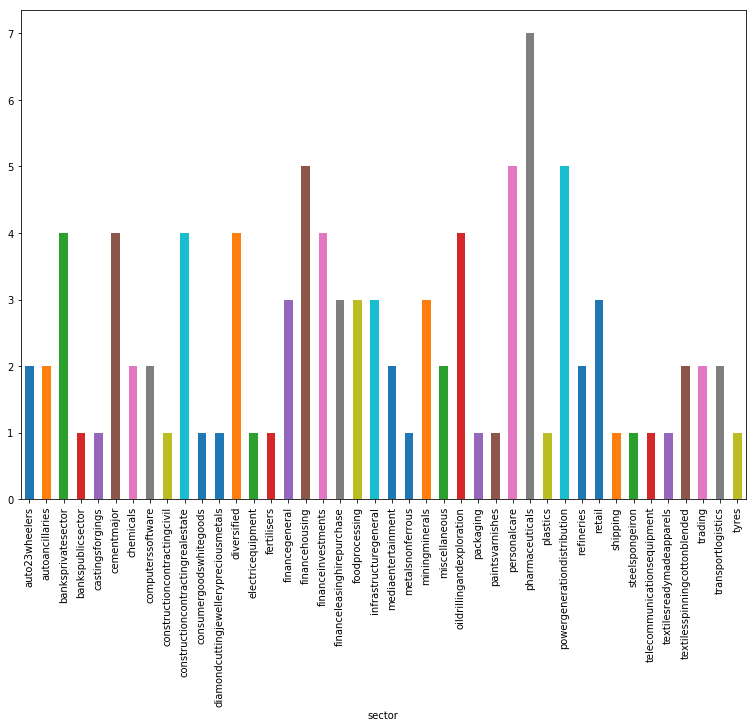

In [42]:
 #########PART 5 below to analyze ##############################
  ##FILES GENERATED: input_scrape_moneycontrol_443_after_cleaning_analyze_v2.csv and moneycontrol_after_cleaning_analyze_forsql.csv
df_analyze=mc.fn_analyze(df_clean) 


In [43]:
df_analyze #final df for analysis

,LINK,MARKETCAP_RS_CR,P_BY_E,BOOK_VALUE_RS,DIV_PERCENT,MARKET_LOT,INDUSTRY_P_BY_E,EPS_TTM,P_BY_C,PRICE_BY_BOOK,DIV_YIELD_PERCENT,FACE_VALUE,sector,company_code,company_name
0,http://www.moneycontrol.com/india/stockpricequote/diversified/3mindia/MI42,22112.99,71.21,1364.33,0.0,1,21.24,275.66,62.76,14.39,NaN,10.0,diversified,MI42,3mindia
1,http://www.moneycontrol.com/india/stockpricequote/cementmajor/acc/ACC06,25131.57,26.48,498.72,260.0,1,35.64,50.54,15.81,2.68,1.94,10.0,cementmajor,ACC06,acc
2,http://www.moneycontrol.com/india/stockpricequote/trading/adanienterprises/AE13,12416.86,63.07,36.04,40.0,1,43.05,1.79,43.59,3.13,0.35,1.0,trading,AE13,adanienterprises
3,http://www.moneycontrol.com/india/stockpricequote/retail/adityabirlafashionretail/PFR,10680.64,90.46,12.43,0.0,1,68.90,1.53,26.77,11.13,NaN,10.0,retail,PFR,adityabirlafashionretail
4,http://www.moneycontrol.com/india/stockpricequote/pharmaceuticals/advancedenzymetechnologies/AET,2413.85,67.35,26.06,20.0,1,24.28,3.21,55.29,8.30,0.19,2.0,pharmaceuticals,AET,advancedenzymetechnologies
5,http://www.moneycontrol.com/india/stockpricequote/transportlogistics/allcargologistics/AGL02,2592.09,90.17,55.81,100.0,1,40.69,1.17,19.87,1.89,1.90,2.0,transportlogistics,AGL02,allcargologistics
6,http://www.moneycontrol.com/india/stockpricequote/cementmajor/ambujacements/AC18,41192.21,32.31,100.59,180.0,1,35.64,6.42,22.28,2.06,1.74,2.0,cementmajor,AC18,ambujacements
7,http://www.moneycontrol.com/india/stockpricequote/telecommunicationsequipment/astramicrowaveproducts/AMP01,851.39,14.02,59.44,50.0,1,27.31,7.01,9.70,1.65,1.02,2.0,telecommunicationsequipment,AMP01,astramicrowaveproducts
8,http://www.moneycontrol.com/india/stockpricequote/plastics/astralpolytechnik/APT02,12085.31,101.50,69.71,50.0,1,84.99,9.94,72.95,14.47,0.05,1.0,plastics,APT02,astralpolytechnik
9,http://www.moneycontrol.com/india/stockpricequote/banksprivatesector/axisbank/AB16,131067.69,477.01,217.28,0.0,1,32.65,1.07,155.14,2.35,NaN,2.0,banksprivatesector,AB16,axisbank


In [44]:
  #########PART 6 below to analyze P/E ################################  
  mc.fn_P_by_e(df_analyze)  

****************************************
NOW ANALYZE BEGINS FOR P/E..                   .....
BUCKET IS: 0.0 to: 5.0
Empty DataFrame
Columns: [company_code, MARKETCAP_RS_CR, P_BY_E]
Index: []
BUCKET IS: 5.0 to: 10.0
   company_code  MARKETCAP_RS_CR  P_BY_E
37          HDI           898.39    9.41
39          HPC         39482.24    6.21
52         KB04          3097.03    9.51
68          N07         24006.81    8.70
69        NMD02         34170.02    8.98
73         OI13         23793.26    8.92
76           PJ          5384.49    9.49
BUCKET IS: 10.0 to: 15.0
   company_code  MARKETCAP_RS_CR  P_BY_E
7         AMP01           851.39   14.02
10          BLC          2403.74   13.01
13          BPC         80598.59   10.18
18          CES         12121.02   13.92
19          CFC          6449.14   13.43
23          C13          4728.60   14.57
29          GIC          1896.90   10.28
38           HZ        116513.17   12.72
43        IHF01         48546.26   13.61
45         IB04      

In [45]:
  rk_df=mc.fn_marketcap(df_analyze)

****************************************
NOW ANALYZE BEGINS for 3rd and 4th highest market cap companies sector wise.                   .....
In analysis data-How many sectors have more than 4 companies
pharmaceuticals                          7
personalcare                             5
powergenerationdistribution              5
financehousing                           5
diversified                              4
oildrillingandexploration                4
banksprivatesector                       4
constructioncontractingrealestate        4
financeinvestments                       4
financegeneral                           3
cementmajor                              3
retail                                   3
infrastructuregeneral                    3
financeleasinghirepurchase               3
foodprocessing                           3
miningminerals                           3
miscellaneous                            2
mediaentertainment                       2
autoancillaries        

DISTRIBUTION OF SECTORS AND COMPANY COUNT
SOME VISUALS AS BELOW:
P/E distribution and count of companies                   
*****************************************************************
*****************************************************************
*****************************************************************
*****************************************************************
MARKETCAP_RS_CR distribution and count of companies                    
*****************************************************************
*****************************************************************
*****************************************************************
*****************************************************************
sectorwise 3rd and 4th and marketcap value on y axis                    
*****************************************************************
*****************************************************************
*****************************************************************
*****

C:\Users\vemu0615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


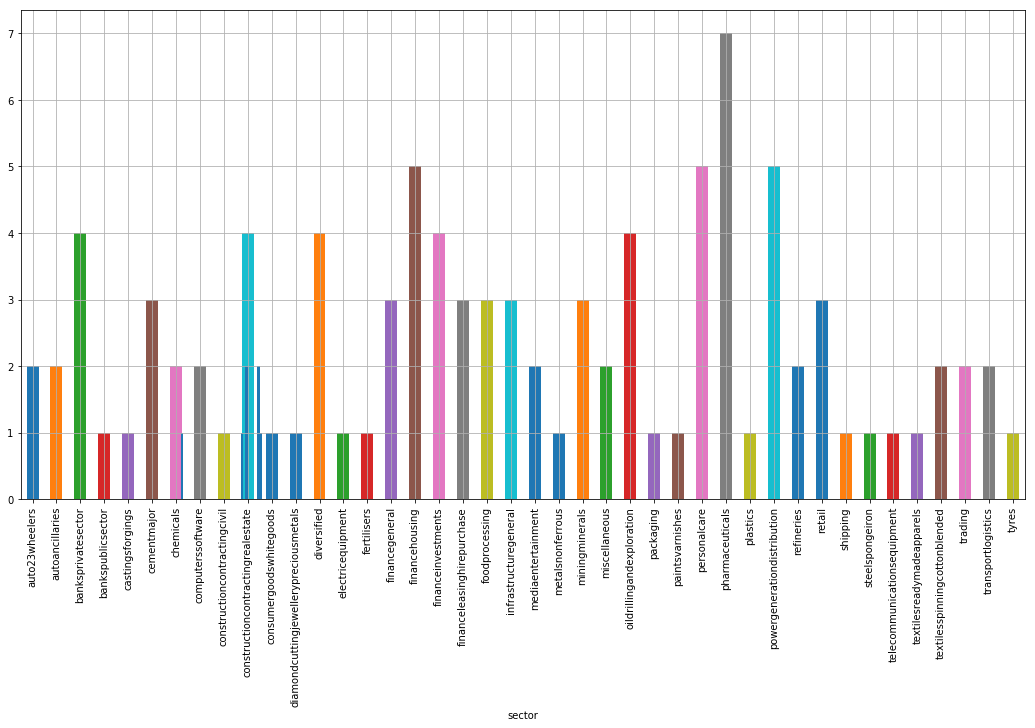

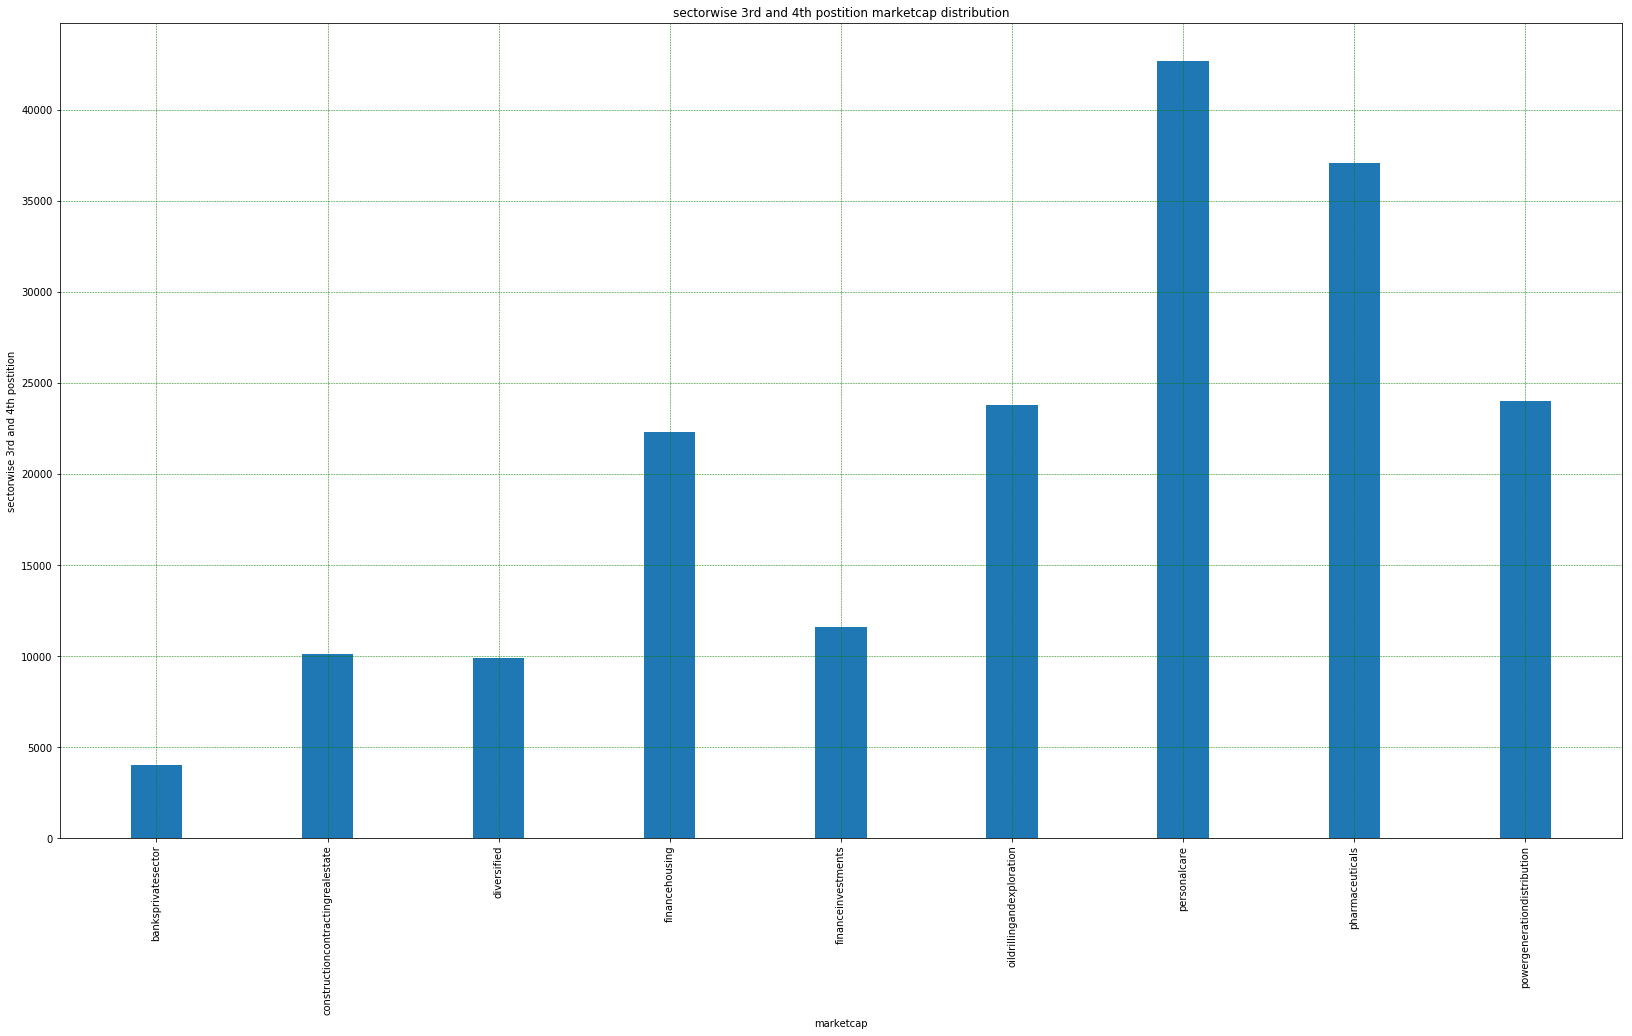

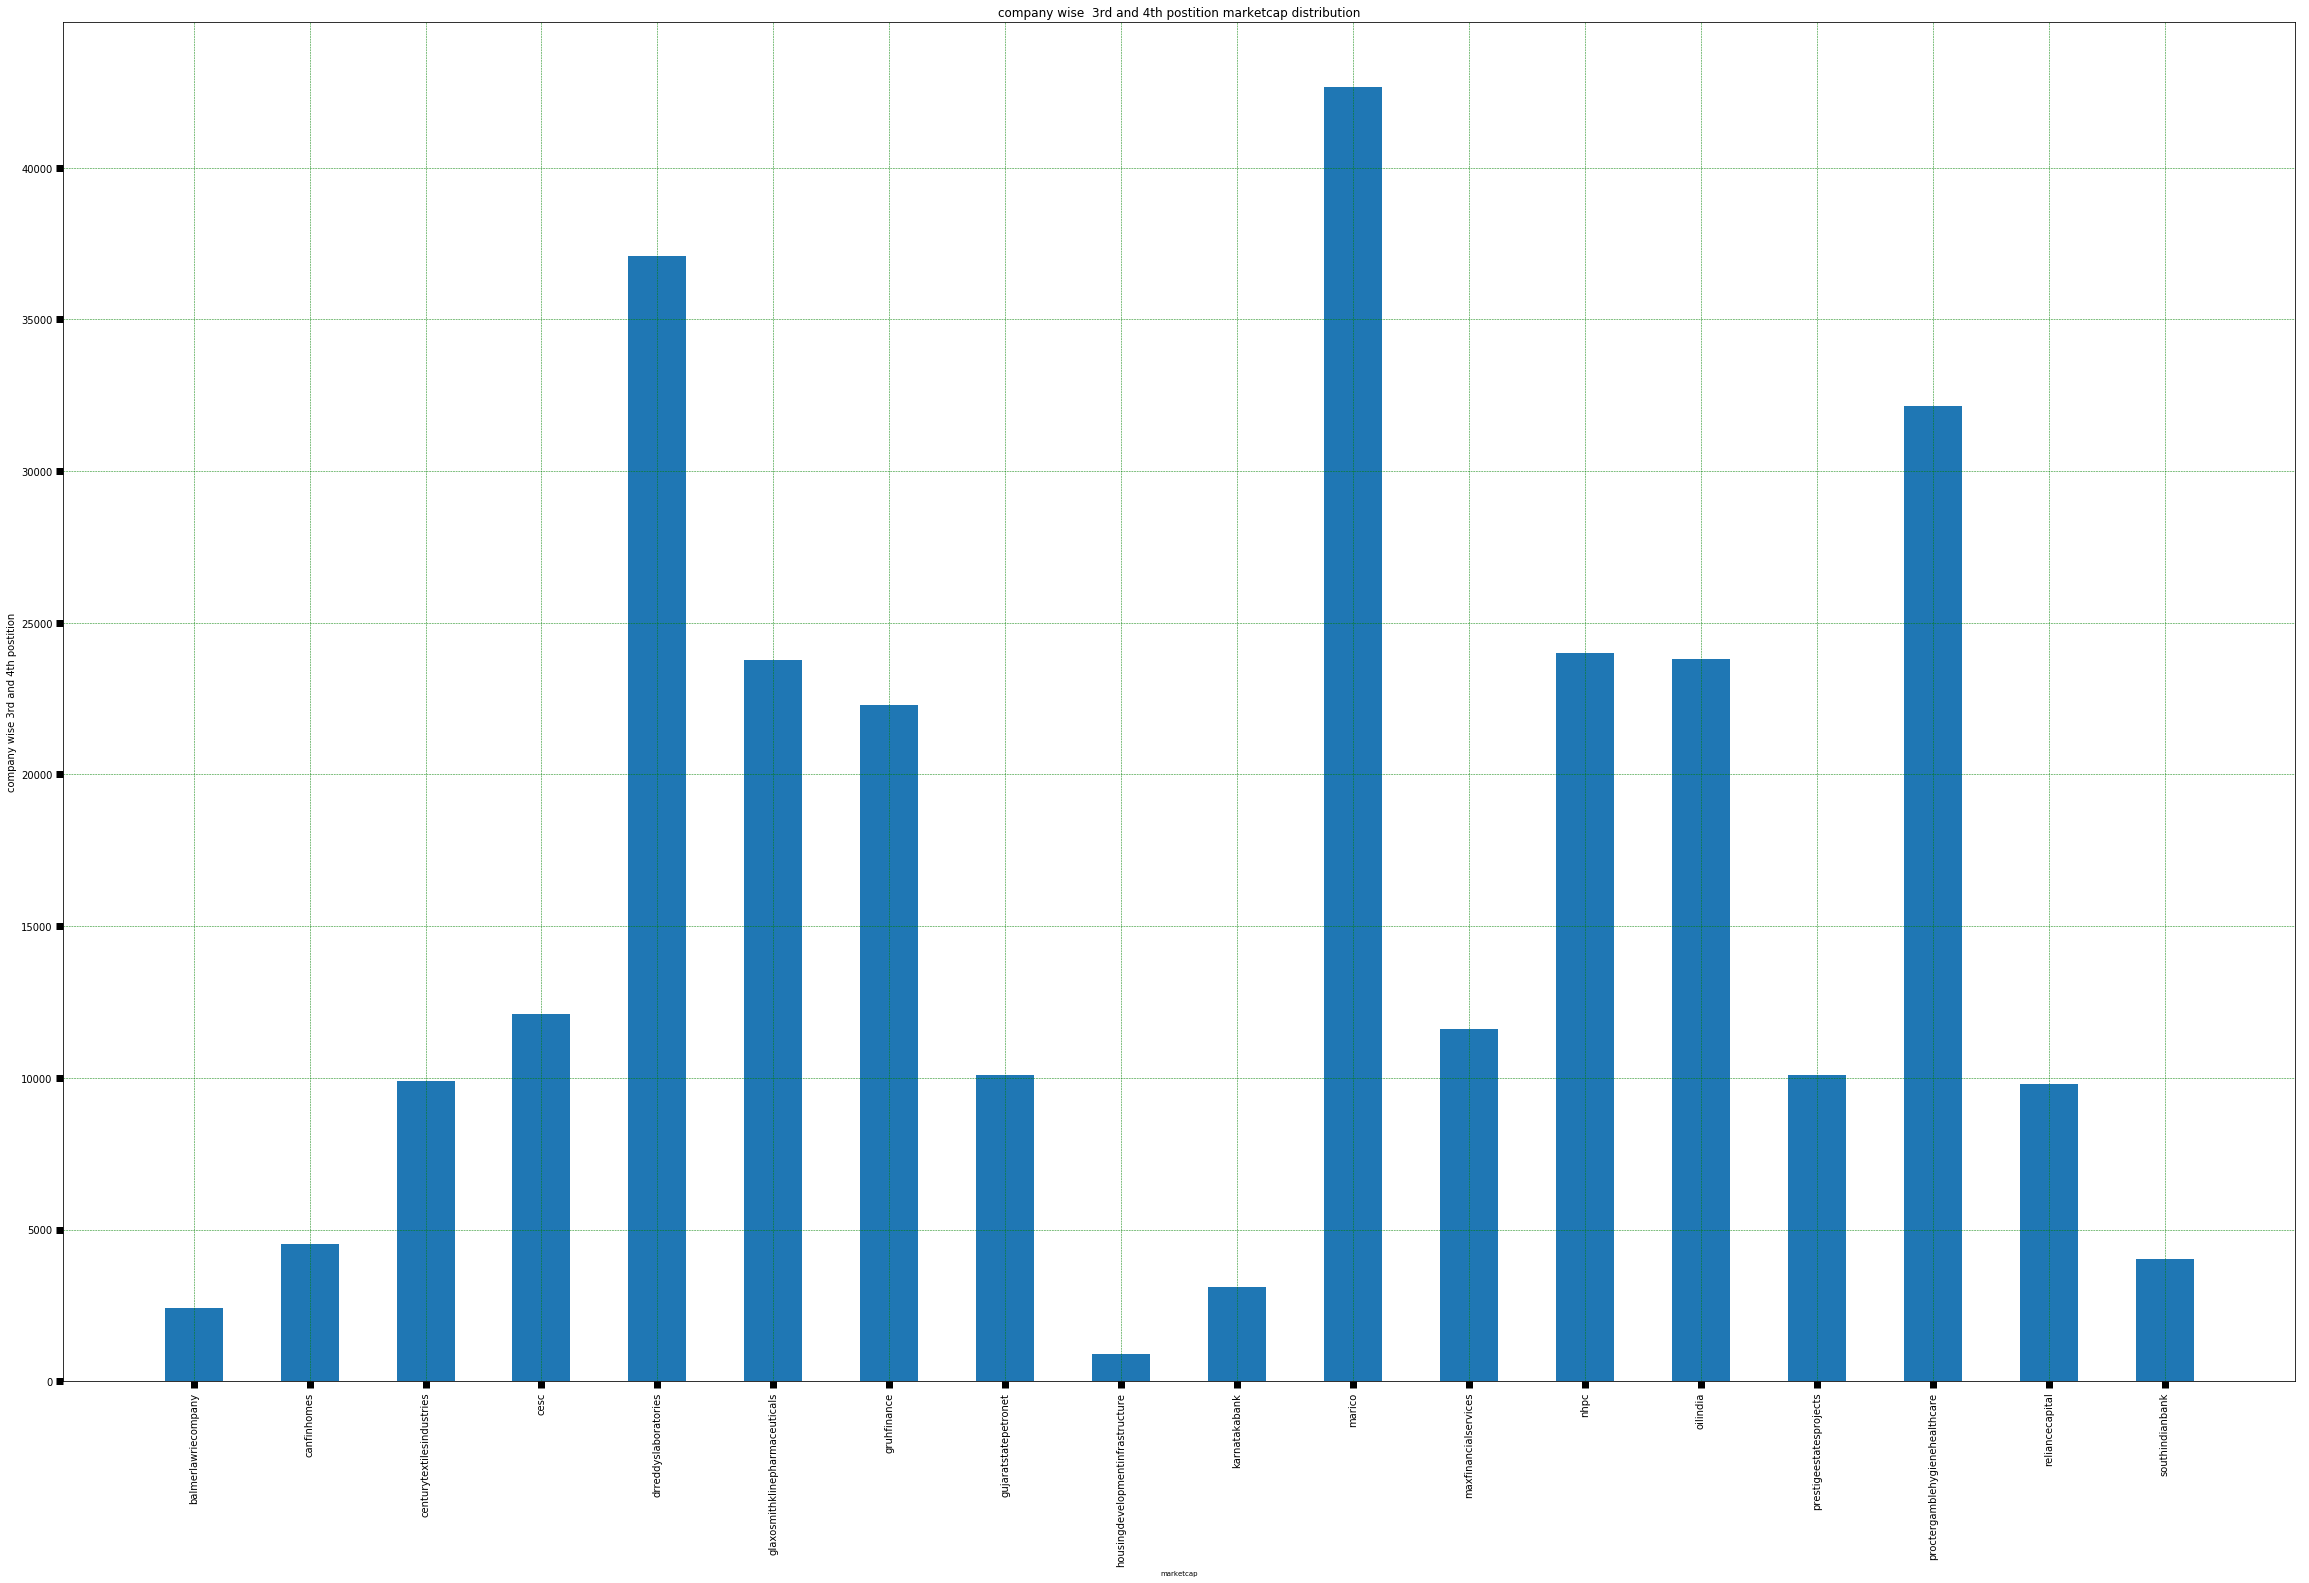

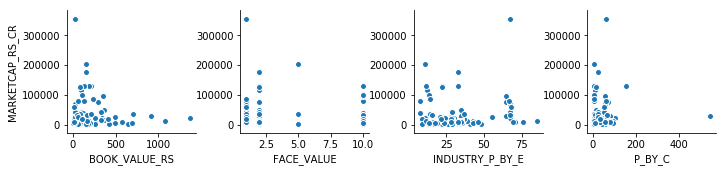

In [46]:
%matplotlib  inline
mc.fn_visual(df_analyze,rk_df)


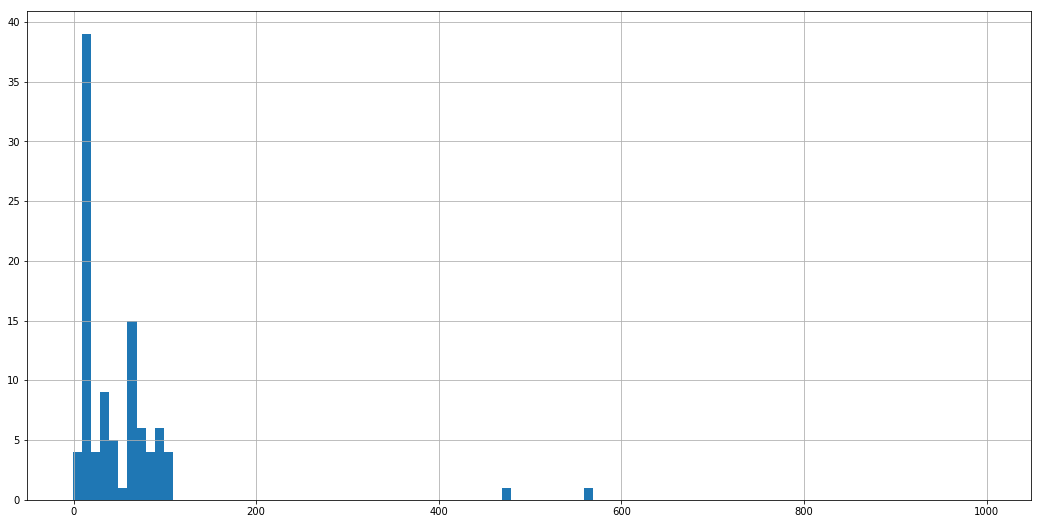

In [47]:
import numpy as np  
bin_values = np.arange(start=-1, stop=1000, step=10)
df_analyze['P_BY_E'].hist(bins=bin_values, figsize=[18,9])